<a href="https://colab.research.google.com/github/VinayakMaharaj/STA365-Final-Project/blob/main/Proj_test_code_JM_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import requests
import pymc as pm
import arviz as az
from pymc.math import invlogit as tt_invlogit

df = pd.read_csv('hhs_filter.csv')

In [ ]:
print(df.head(n=5))

   Unnamed: 0   GAME_ID LOCATION  SHOT_NUMBER  PERIOD  GAME_HALF GAME_CLOCK  \
0           0  21400907        H            1       1          1       9:49   
1           1  21400907        H            2       1          1       7:26   
2           2  21400907        H            3       1          1       5:34   
3           3  21400907        H            4       1          1       5:00   
4           4  21400907        H            5       1          1       3:33   

   GAME_CLOCK_DECIMAL  SHOT_CLOCK  DRIBBLES  ...  PLAYER_WEIGHT  EXCLUDE  \
0            9.816667        16.3         2  ...       86.18248        1   
1            7.433333        16.6         0  ...       86.18248        1   
2            5.566667        11.0         0  ...       86.18248        1   
3            5.000000        18.5         2  ...       86.18248        1   
4            3.550000         NaN         1  ...       86.18248        1   

  SEASON_SHOTS_TAKEN GAME_SHOTS_TAKEN  SHOT_STREAK  HOT_HAND_SHOT_ST

In [ ]:
#need to remove some variables we dont need for the analysis
df2 = df.iloc[:, 1:]

df3 = df2.drop(columns= ["GAME_ID", "GAME_CLOCK","SHOT_STREAK", "GAME_HALF",
                           "player_name", "player_id", "GAME_SHOTS_TAKEN",
                           "SHOT_RESULT", "REFORMATED_DEF_NAME",
                           "CLOSEST_DEFENDER_PLAYER_ID", "SEASON_SHOTS_TAKEN" ])

#remove any rows that have some kind of error
df3 = df3[df3.EXCLUDE == 0]

#no longer need exclude and fgm column
clean = df3.drop(columns= ["EXCLUDE"])

# replace 'A' with '0'
clean['LOCATION'].replace('A', 0, inplace=True)
# replace 'A' with '0'
clean['LOCATION'].replace('H', 1, inplace=True)
# when shot clock is NaN, we will replace shot clock with game clock value
clean.loc[df['SHOT_CLOCK'].isnull(),'SHOT_CLOCK'] = df['GAME_CLOCK_DECIMAL']

print(clean.head(n=5))

    LOCATION  SHOT_NUMBER  PERIOD  GAME_CLOCK_DECIMAL  SHOT_CLOCK  DRIBBLES  \
16         0            1       1            6.266667        15.4         0   
17         0            2       1            5.383333        16.2        11   
18         0            3       1            5.233333        18.2         0   
19         0            4       3            9.200000        12.1         0   
20         0            5       3            2.100000        19.4         4   

    SHOT_DIST  PTS_TYPE  DEFENDER_HEIGHT_CM  DEFENDER_WEIGHT_KG  \
16       23.2         3              190.50            90.71840   
17       15.6         2              190.50            86.18248   
18       23.1         3              198.12            99.79024   
19       24.6         3              190.50            90.71840   
20       25.7         3              190.50            90.71840   

    CLOSE_DEF_DIST  FGM  PLAYER_HEIGHT  PLAYER_WEIGHT  HOT_HAND_SHOT_STREAK2  \
16             4.1    0          190.5    

In [ ]:
len(clean)

13579

In [ ]:
np.random.seed(23)
N = 250 #number of samples to make code run faster

#force 250 shots to be hot
# will divide the sample dataset into 2 subdatasets
base = clean[(clean.HOT_HAND_SHOT_STREAK3 ==0)].sample(N, replace=False)
hot = clean[(clean.HOT_HAND_SHOT_STREAK3 ==1) ].sample(N, replace = False)

samp = pd.concat([base,hot])

#maybe only for players with high number of hot hand shots
#removes noise and focuses the inference and justifaction fo smaller

print(samp.head(n=5))



       LOCATION  SHOT_NUMBER  PERIOD  GAME_CLOCK_DECIMAL  SHOT_CLOCK  \
4499          1            6       2            2.133333        13.8   
532           1           11       3            7.666667        19.0   
4163          0           16       4            4.433333        10.1   
4126          0           13       3            9.983333         9.5   
11441         1            7       3            8.250000        15.0   

       DRIBBLES  SHOT_DIST  PTS_TYPE  DEFENDER_HEIGHT_CM  DEFENDER_WEIGHT_KG  \
4499          1        5.5         2              195.58          102.058200   
532           6       24.0         3              182.88           79.378600   
4163          0        2.0         2              193.04           88.450440   
4126          2        5.2         2              200.66          104.326160   
11441         9       24.9         3              205.74          102.965384   

       CLOSE_DEF_DIST  FGM  PLAYER_HEIGHT  PLAYER_WEIGHT  \
4499              3.9    1

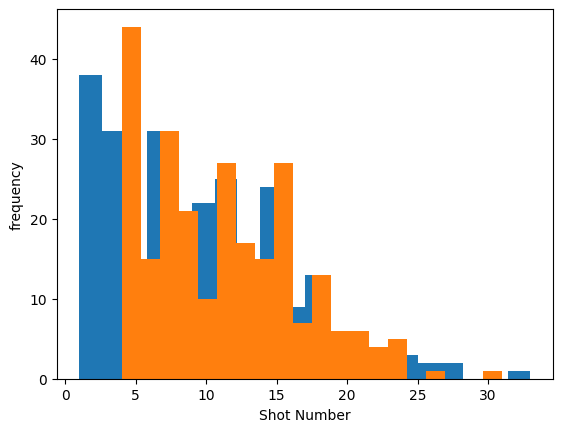

In [ ]:
# Exploratory Data Analysis
plt.hist(base['SHOT_NUMBER'],bins=20)
plt.hist(hot['SHOT_NUMBER'],bins=20)
plt.xlabel('Shot Number')
plt.ylabel('frequency')
plt.show()

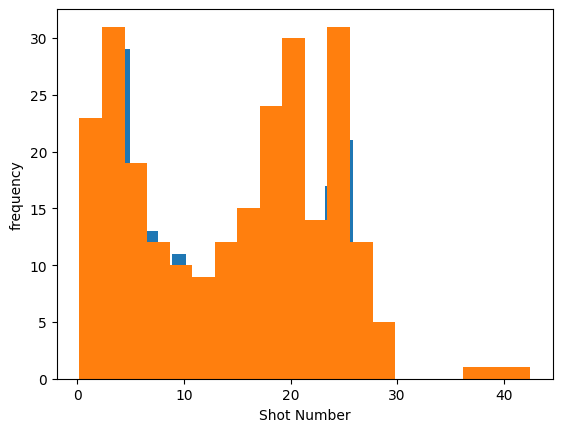

In [ ]:
# Exploratory Data Analysis
plt.hist(base['SHOT_DIST'],bins=20)
plt.hist(hot['SHOT_DIST'],bins=20)
plt.xlabel('Shot Number')
plt.ylabel('frequency')
plt.show()

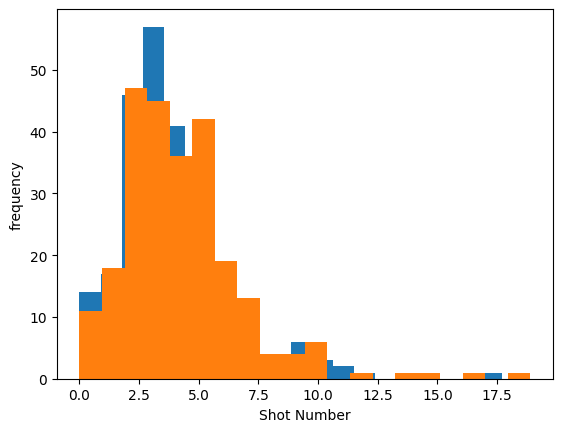

In [ ]:
# Exploratory Data Analysis
plt.hist(base['CLOSE_DEF_DIST'],bins=20)
plt.hist(hot['CLOSE_DEF_DIST'],bins=20)
plt.xlabel('Shot Number')
plt.ylabel('frequency')
plt.show()

In [ ]:
samp.describe()

,LOCATION,SHOT_NUMBER,PERIOD,GAME_CLOCK_DECIMAL,SHOT_CLOCK,DRIBBLES,SHOT_DIST,PTS_TYPE,DEFENDER_HEIGHT_CM,DEFENDER_WEIGHT_KG,CLOSE_DEF_DIST,FGM,PLAYER_HEIGHT,PLAYER_WEIGHT,HOT_HAND_SHOT_STREAK2,HOT_HAND_SHOT_STREAK3,GAME_TIME_ELAPSED,num_HHS,num_not_HHS
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.580000,10.268000,2.502000,4.799333,12.025933,3.218000,13.819600,2.230000,201.972400,102.434042,4.101600,0.508000,200.126600,100.436155,0.552000,0.500000,25.196667,67.430000,865.404000
std,0.494053,5.896925,1.122727,3.249835,6.103627,4.689398,8.814977,0.421254,8.884536,11.705415,2.525517,0.500437,8.744983,12.046081,0.497787,0.500501,13.991615,10.959988,87.173018
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.200000,2.000000,175.260000,76.203456,0.000000,0.000000,182.880000,79.378600,0.000000,0.000000,0.233333,54.000000,653.000000
25%,0.000000,5.750000,1.000000,1.979167,7.575000,0.000000,4.875000,2.000000,195.580000,92.986360,2.575000,0.000000,190.500000,87.543256,0.000000,0.000000,11.979167,58.000000,821.000000
50%,1.000000,9.000000,3.000000,4.525000,12.000000,2.000000,15.000000,2.000000,203.200000,102.058200,3.500000,1.000000,200.660000,99.790240,1.000000,0.500000,24.858333,64.000000,888.000000
75%,1.000000,14.000000,3.000000,7.133333,16.825000,4.000000,21.200000,2.000000,208.280000,111.130040,5.225000,1.000000,208.280000,113.398000,1.000000,1.000000,35.862500,72.000000,907.000000
max,1.000000,33.000000,5.000000,11.833333,24.000000,24.000000,42.500000,3.000000,218.440000,131.541680,18.900000,1.000000,213.360000,117.933920,1.000000,1.000000,50.683333,96.000000,990.000000


In [ ]:
def predictor_matrix(data: pd.DataFrame, col_names: list, adjust_std=False) -> np.array:
    """
    given a dataframe  and list  containing p column names,
    return a numpy (N x p+1) matrix X with N observations and p
    standardized predictors (first column is the intercept column full of ones)
    if  == True, then use n-1 as divisor for std rather than n when
    standardizing predictors
    """
    predictors = data[col_names].to_numpy()
    normd_predictors = (predictors - np.mean(predictors, axis=0, keepdims=True)) / np.std(predictors, axis=0, keepdims=True, ddof=adjust_std)
    return np.insert(normd_predictors, 0, 1, axis=1)


In [ ]:
# model 1
# list of column names you want to keep to use as predictors:
col_names1 = ['LOCATION', 'SHOT_NUMBER', 'PERIOD', 'GAME_CLOCK_DECIMAL',
            'SHOT_CLOCK', 'DRIBBLES', 'SHOT_DIST', 'DEFENDER_HEIGHT_CM',
             'DEFENDER_WEIGHT_KG', 'CLOSE_DEF_DIST', 'PLAYER_HEIGHT',
             'PLAYER_WEIGHT', 'HOT_HAND_SHOT_STREAK3']
X1 = predictor_matrix(samp, col_names1)
P1 = X1.shape[1] - 1

#Look into colinearity, and exclude some with high colinearity

In [ ]:
# model 2

col_names2 = ['LOCATION', 'SHOT_CLOCK', 'SHOT_DIST', 'DEFENDER_HEIGHT_CM',
              'CLOSE_DEF_DIST','PLAYER_HEIGHT', 'HOT_HAND_SHOT_STREAK3']
X2 = predictor_matrix(samp, col_names2)
P2 = X2.shape[1] - 1

In [ ]:
y2 = np.zeros((2*N,1))
y2[:,0] = samp['FGM']

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = pd.DataFrame(X1)
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = ['FGM','LOCATION', 'SHOT_NUMBER', 'PERIOD', 'GAME_CLOCK_DECIMAL',
            'SHOT_CLOCK', 'DRIBBLES', 'SHOT_DIST', 'DEFENDER_HEIGHT_CM',
             'DEFENDER_WEIGHT_KG', 'CLOSE_DEF_DIST', 'PLAYER_HEIGHT',
             'PLAYER_WEIGHT', 'HOT_HAND_SHOT_STREAK3']

vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data)

#anything above 5 is high multicolinearity

                  feature       VIF
0                     FGM  1.000000
1                LOCATION  1.016163
2             SHOT_NUMBER  4.081128
3                  PERIOD  3.760839
4      GAME_CLOCK_DECIMAL  1.431186
5              SHOT_CLOCK  1.242037
6                DRIBBLES  1.472780
7               SHOT_DIST  1.475804
8      DEFENDER_HEIGHT_CM  3.416545
9      DEFENDER_WEIGHT_KG  3.484530
10         CLOSE_DEF_DIST  1.258158
11          PLAYER_HEIGHT  7.704312
12          PLAYER_WEIGHT  6.803212
13  HOT_HAND_SHOT_STREAK3  1.129418


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = pd.DataFrame(X2)
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = ['FGM','LOCATION', 'SHOT_CLOCK', 'SHOT_DIST', 'DEFENDER_HEIGHT_CM',
               'CLOSE_DEF_DIST', 'PLAYER_HEIGHT', 'HOT_HAND_SHOT_STREAK3']

vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data)

#anything above 5 is high multicolinearity

                 feature       VIF
0                    FGM  1.000000
1               LOCATION  1.010838
2             SHOT_CLOCK  1.102264
3              SHOT_DIST  1.401935
4     DEFENDER_HEIGHT_CM  1.175083
5         CLOSE_DEF_DIST  1.238170
6          PLAYER_HEIGHT  1.220085
7  HOT_HAND_SHOT_STREAK3  1.027967


In [ ]:
#MODEL 1 SPIKE SLAB IMPLEMENTATION



In [ ]:
import pymc as pm; import numpy as np
#model 1
#look at coords and use dims as shape, and as dims in the coords

with pm.Model(coords={"cluster": range(P2+1)}) as MLR:
    betas = pm.MvNormal('betas', mu= np.zeros((P2+1,1)), cov=np.eye(P2+1), shape=(P2+1,1), dims = 'cluster')
    y = pm.Bernoulli('y', logit_p = pm.math.dot(X2, betas), observed = y2)
with MLR:
    idata = pm.sample()

# do more analysis / visualizations

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


HMC Split-Rhats {'betas': array([[1.00109557, 1.00061826, 1.00006301, 1.0009624 , 0.99959747,
        0.99967904, 1.00357749, 0.99946592],
       [1.00113506, 1.00662974, 1.00104425, 1.0021209 , 0.99981627,
        1.00212425, 0.99980363, 1.0005532 ],
       [1.00001404, 1.00227041, 1.00022181, 1.00092767, 0.99972548,
        0.99994259, 1.00144968, 1.00040955],
       [0.99983908, 1.00107079, 1.00083779, 1.00100471, 1.0006233 ,
        1.00005458, 1.00132395, 0.99926816],
       [0.99948822, 0.99967781, 1.00137458, 1.00158927, 1.0005198 ,
        1.0001955 , 1.000259  , 1.00059767],
       [1.00181829, 1.0023002 , 1.00157816, 1.00076812, 1.000084  ,
        0.99945627, 1.00281056, 1.00223783],
       [1.0031268 , 1.00047962, 1.00074601, 1.00214074, 1.00217695,
        1.00204252, 0.99946659, 1.00310352],
       [1.00344316, 1.00303103, 0.99974457, 1.00050439, 0.99981451,
        0.99933733, 1.00012114, 1.00050961]])} | 

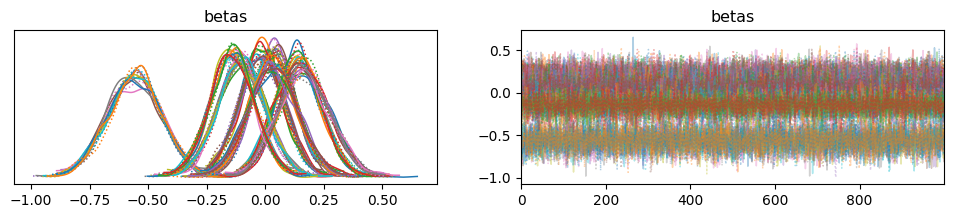

In [ ]:
import arviz as az; import matplotlib.pyplot as plt;
az.plot_trace(idata);
print("HMC Split-Rhats", {k: np.round(v.values,P2+1) for k,v in az.rhat(idata).items()}, end=' | ')
# None of the split R hats values is greater than 1.05 and there is no sign of divergence.

In [ ]:

import pymc as pm; import numpy as np
from pymc.math import invlogit as tt_invlogit
#model 2
with pm.Model() as MLR:
    #LKJ cov
    packed_L = pm.LKJCholeskyCov("packed_L", n= P2+1, eta=2.0, sd_dist=pm.HalfCauchy.dist(beta=10, shape=P2+1), compute_corr=False)
    L = pm.expand_packed_triangular(P2+1, packed_L);
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))

    #Horsehoe prior to help distinguish useful predictors
    tau_0 = 0.03;
    tau = pm.HalfCauchy('tau', beta=tau_0, shape=1)
    lambdas = pm.HalfCauchy('lambdas', beta=1, shape=(P2+1));
    weights = pm.Normal('weights', mu=0, sigma=tau*lambdas, shape=(P2+1))
    betas = pm.MvNormal('betas', mu= np.zeros((P2+1,1)), cov= Sigma, shape=(P2+1))

    y = pm.Bernoulli('y', logit_p = pm.math.dot(X2, betas*weights), observed = y2)
with MLR:
    MH = pm.Metropolis([betas], S=np.array([0.1]), tune=False, tune_interval=0)
    idata_MH = pm.sample(step=MH)

    #for proj we can make note on how long it takes computationally to use chol
    #problem in mixing?
    #invalid value could be near 0 value in log

/usr/local/lib/python3.10/dist-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()


ValueError: conflicting sizes for dimension 'cluster': length 36 on the data but length 8 on coordinate 'cluster'

In [ ]:
import arviz as az; import matplotlib.pyplot as plt;
az.plot_trace(idata_MH);
print("HMC Split-Rhats", {k: np.round(v.values,P2+1) for k,v in az.rhat(idata_MH).items()}, end=' | ')
# None of the split R hats values is greater than 1.05 and there is no sign of divergence.

NameError: name 'idata_MH' is not defined

In [ ]:
import pymc as pm; import numpy as np
from pymc.math import invlogit as tt_invlogit

#model 3
with pm.Model(coords={"cluster": range(P2+1)}) as MLR:

    #Horsehoe prior to help distinguish useful predictors
    tau_0 = 1;
    tau = pm.HalfCauchy('tau', beta=tau_0, shape=1, dims = 'cluster')
    lambdas = pm.HalfCauchy('lambdas', beta=1, shape=(P2+1), dims = 'cluster');
    weights = pm.Normal('weights', mu=0, sigma=tau*lambdas, shape=(P2+1), dims = 'cluster')
    betas = pm.MvNormal('betas', mu= np.zeros((P2+1,1)), cov= np.eye(P2+1), shape=(P2+1), dims = 'cluster')

    y = pm.Bernoulli('y', logit_p = pm.math.dot(X2, betas*weights), observed = y2)
with MLR:
    idata = pm.sample()

    #misspecified horshoe bc not shrinking to 0
    #regularized horseshoe, seeing something interestin with bi-modal, report on

HMC Split-Rhats {'weights': array([1.83274888, 1.8312698 , 1.00002871, 1.00314565, 1.82686488,
       1.50528481, 1.00266533, 1.00456645]), 'betas': array([[1.07434768, 1.06799423, 1.00032553, 0.99976236, 1.06707424,
        1.04240182, 1.00307437, 1.00000265],
       [1.01087484, 1.01819662, 1.00469562, 1.00451524, 1.01431814,
        1.00836047, 1.00354465, 1.00431932],
       [1.71979801, 1.7491001 , 1.00054927, 1.00075094, 1.75319985,
        1.46351635, 1.00031167, 1.00046301],
       [1.83248697, 1.82741133, 1.00046071, 1.00298738, 1.82785925,
        1.51783179, 1.00044958, 1.00366402],
       [1.24647145, 1.23131638, 1.00136772, 1.00235101, 1.23441493,
        1.16932848, 0.99975302, 1.00367548],
       [1.3687139 , 1.30200506, 1.00001919, 1.00120444, 1.3374475 ,
        1.22993162, 1.00184089, 1.00052182],
       [1.11558113, 1.13877506, 1.00131842, 1.00142737, 1.1504586 ,
        1.09963974, 1.00195926, 1.00127303],
       [1.69378114, 1.69089191, 1.00271376, 1.00300162, 1.68

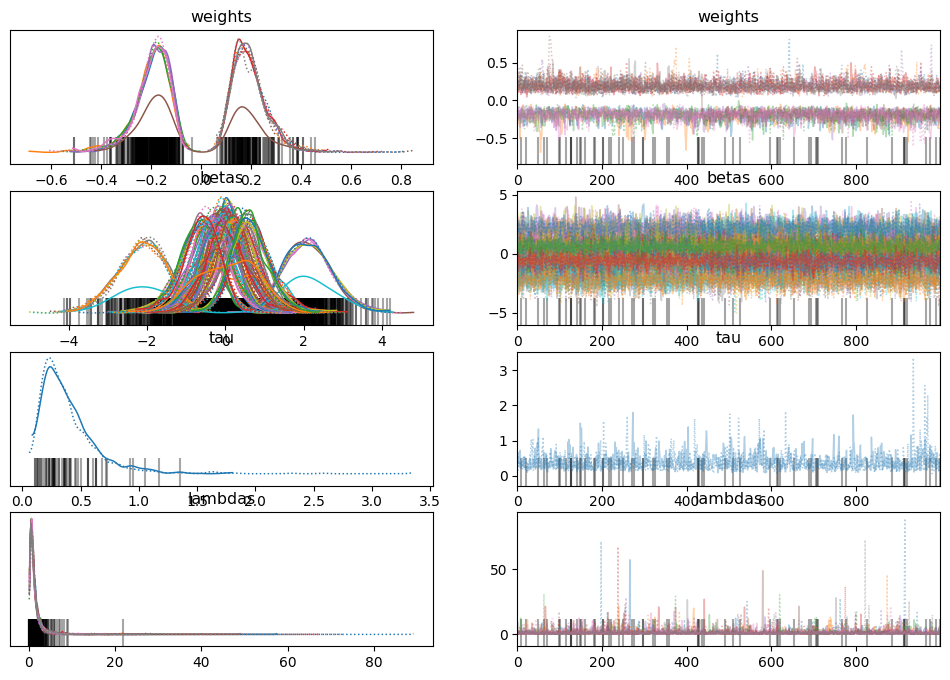

In [ ]:
import arviz as az; import matplotlib.pyplot as plt;
az.plot_trace(idata);
print("HMC Split-Rhats", {k: np.round(v.values,P2+1) for k,v in az.rhat(idata).items()}, end=' | ')
# None of the split R hats values is greater than 1.05 and there is no sign of divergence.


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
weights[0]   0.271  0.095   0.109    0.439      0.004    0.003     669.0   
weights[1]  -0.007  0.282  -0.415    0.412      0.191    0.158       3.0   
weights[2]   0.273  0.095   0.122    0.441      0.005    0.003     477.0   
weights[3]  -0.268  0.086  -0.436   -0.132      0.004    0.003     549.0   
weights[4]  -0.001  0.286  -0.454    0.385      0.192    0.159       3.0   
...            ...    ...     ...      ...        ...      ...       ...   
betas[9, 5] -0.447  0.380  -1.195    0.243      0.009    0.008    1892.0   
betas[9, 6]  0.009  0.586  -1.154    0.979      0.331    0.260       3.0   
betas[9, 7] -0.435  0.377  -1.110    0.271      0.009    0.008    1890.0   
betas[9, 8]  0.438  0.382  -0.223    1.223      0.009    0.008    1984.0   
betas[9, 9] -0.448  0.372  -1.225    0.176      0.009    0.008    1767.0   

             ess_tail  r_hat  
weights[0]      556.0   1.00  
weights[1]       90.0   1

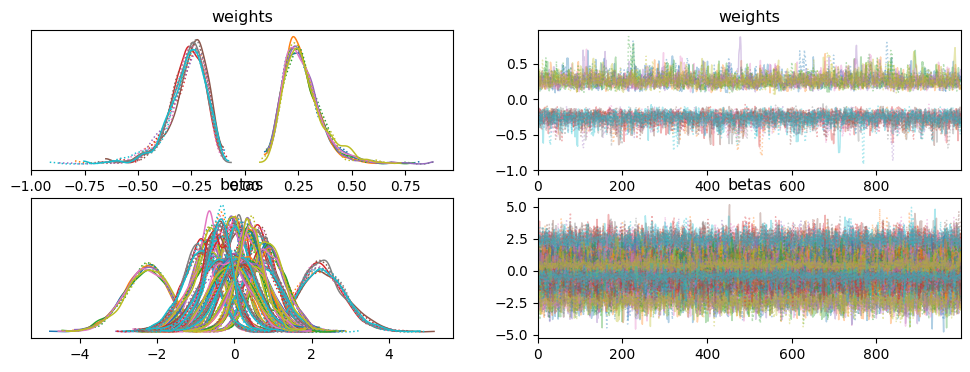

/usr/local/lib/python3.10/dist-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (110) in plot_posterior, generating only 40 plots
  warnings.warn(


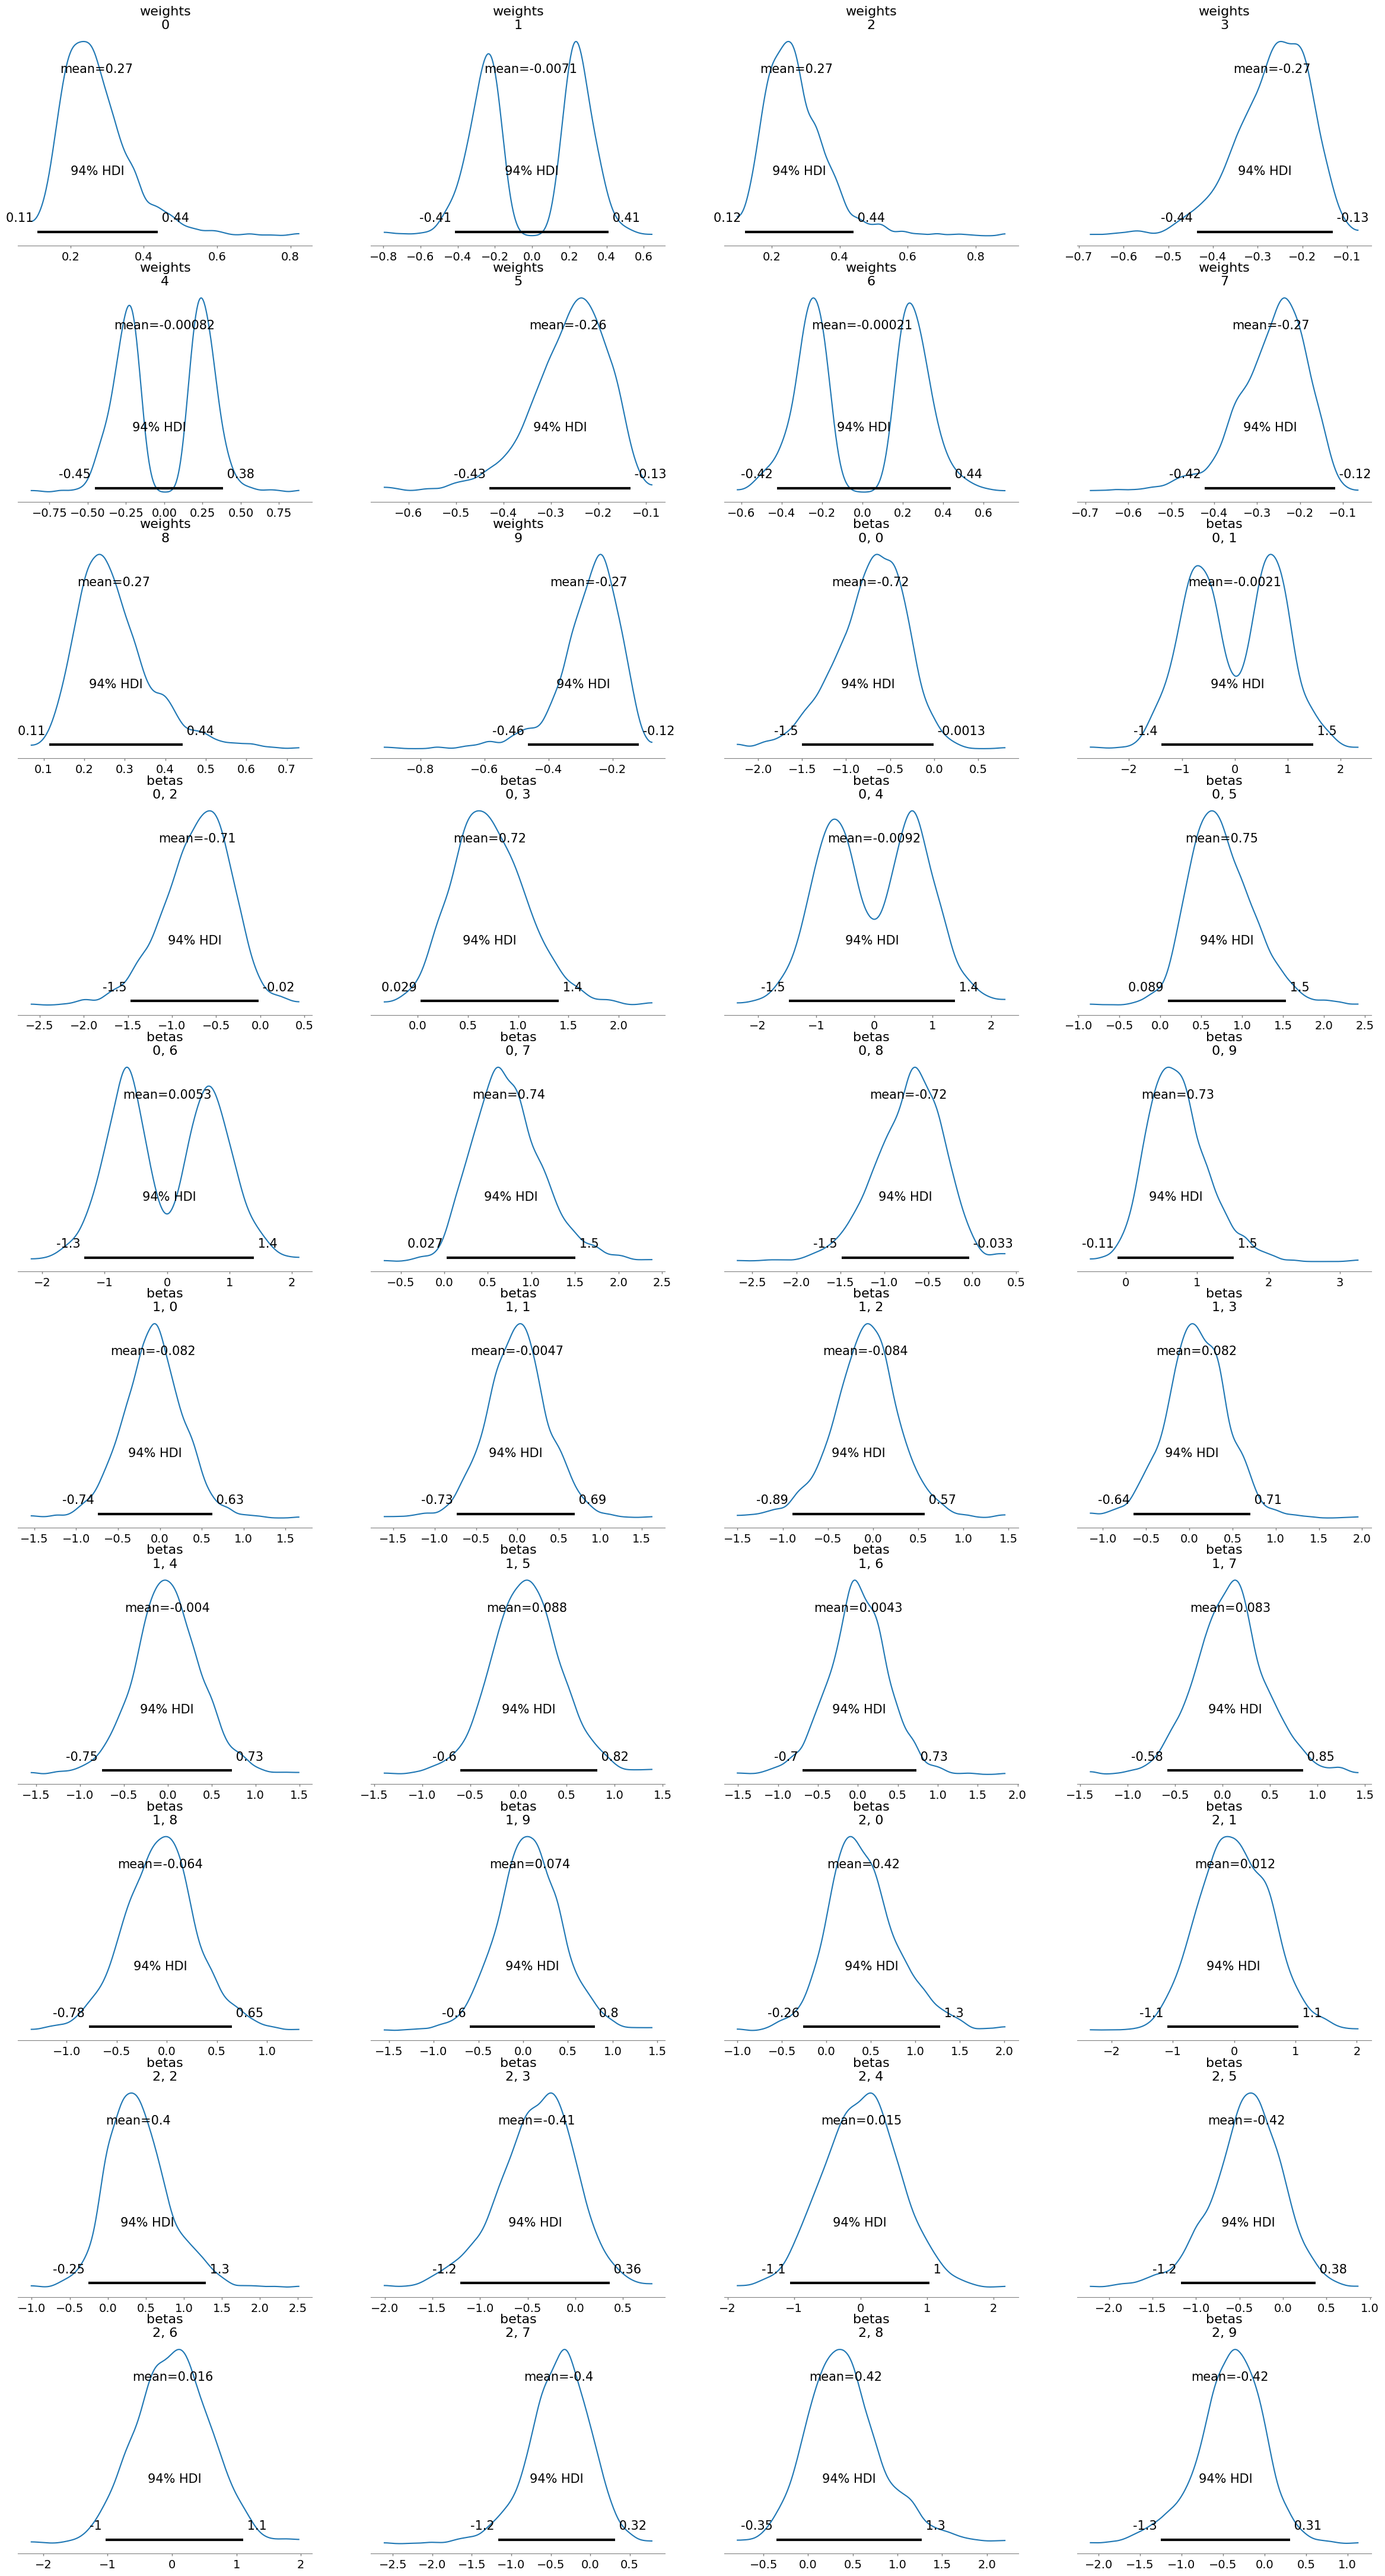

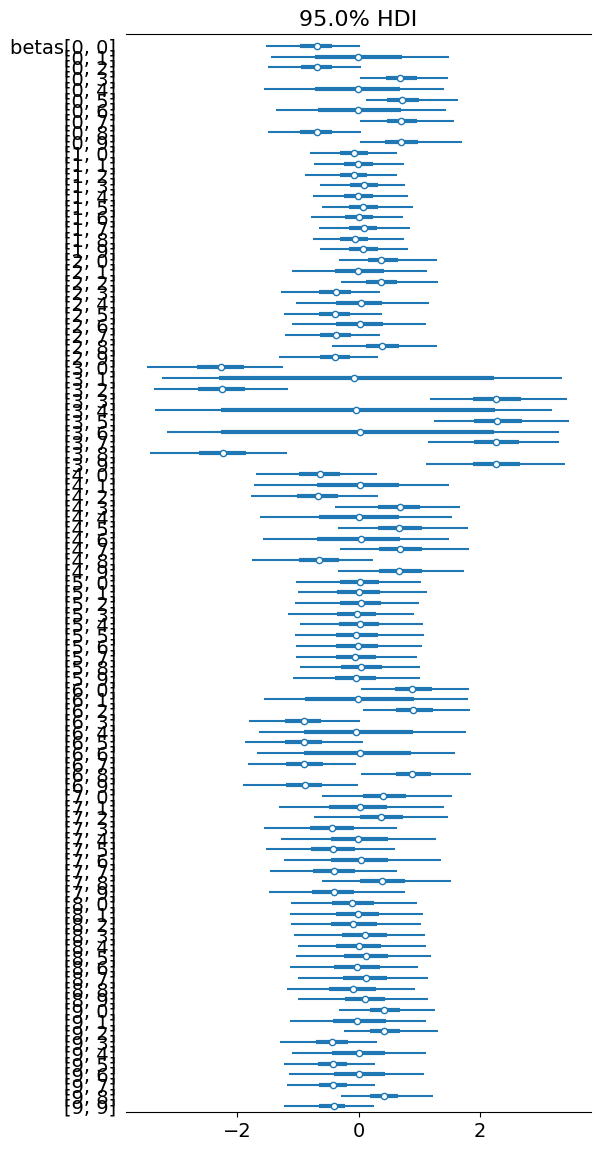

/usr/local/lib/python3.10/dist-packages/arviz/plots/backends/matplotlib/pairplot.py:232: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


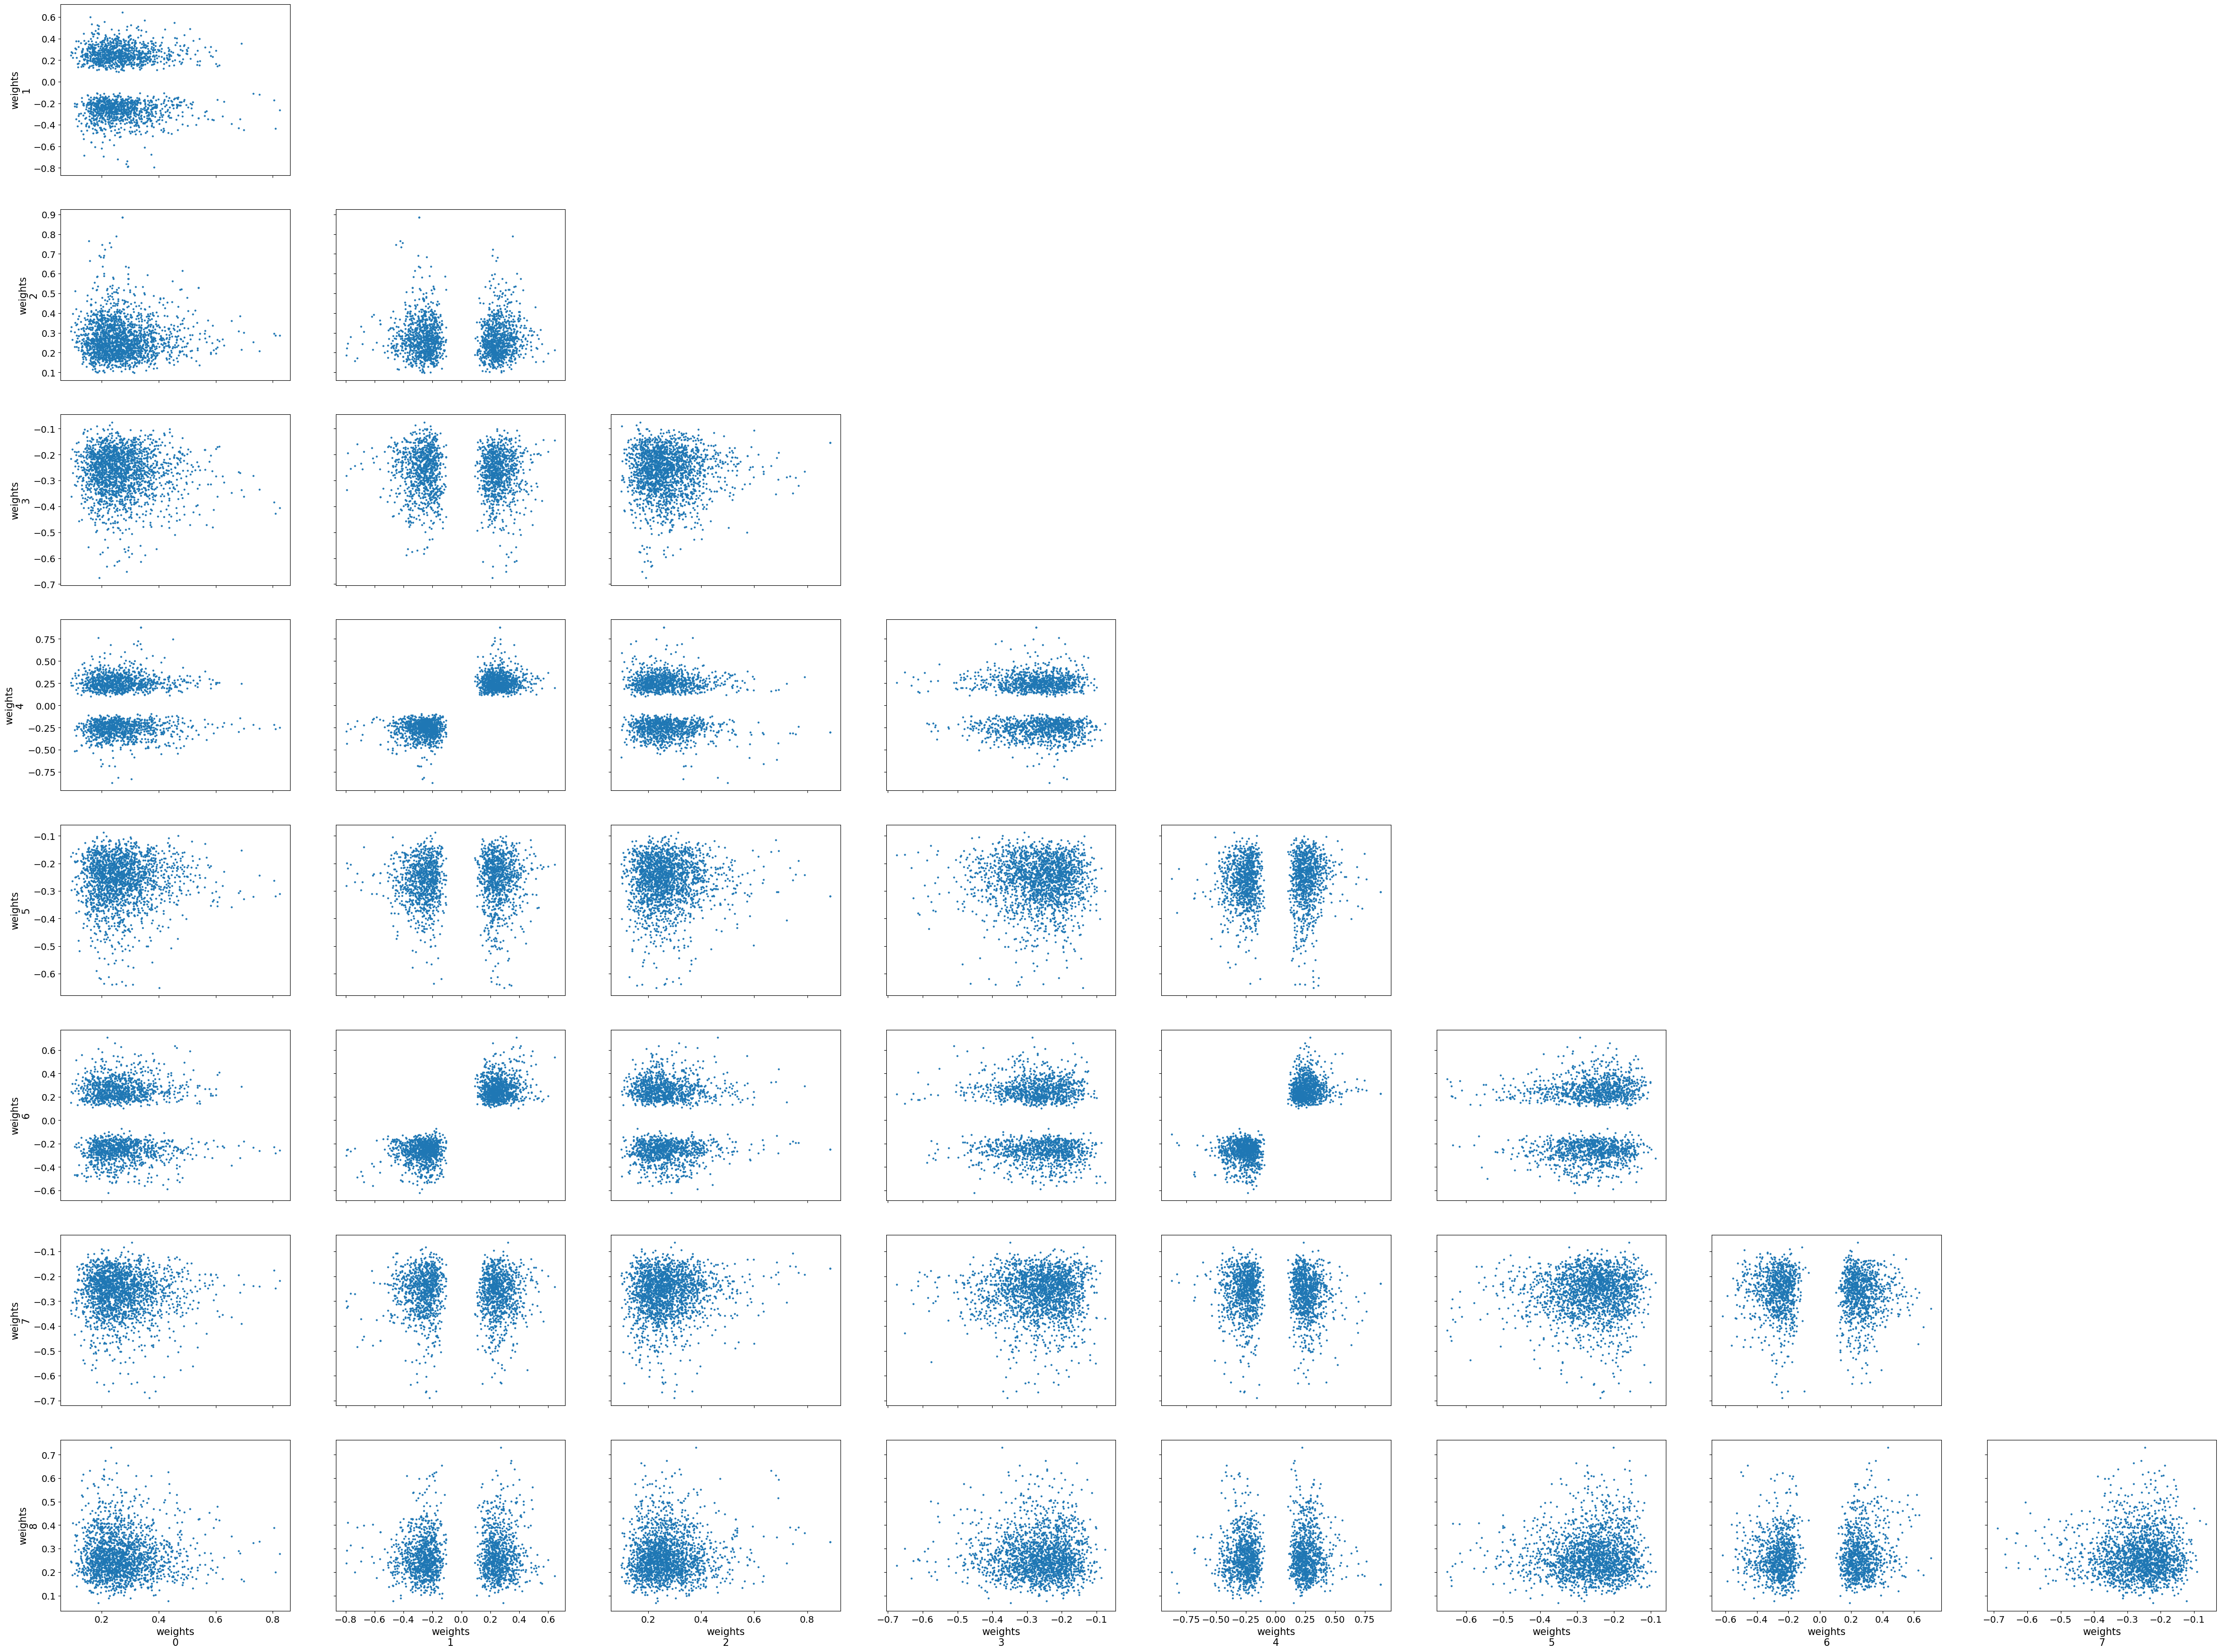

In [ ]:

# Analysis and Visualization
# Summary statistics
summary = az.summary(idata, var_names=['weights', 'betas'])
print(summary)

# Trace plot
az.plot_trace(idata, var_names=['weights', 'betas'])
plt.show()

# Posterior plot
az.plot_posterior(idata, var_names=['weights', 'betas'])
plt.show()

# Forest plot for betas
az.plot_forest(idata, var_names=['betas'], combined=True, hdi_prob=0.95)
plt.show()

# Pair plot for exploring relationships between parameters
az.plot_pair(idata, var_names=['weights', 'betas'])
plt.show()
